In [2]:
%load_ext autoreload
%autoreload 2

In [ ]:
import sys
import importlib
import gc
import glob
import random
from itertools import combinations

import numpy as np
import sklearn
from sklearn import metrics

import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns

import pyemma
import msmtools
import mdtraj as md

import ivac
import extq

In [ ]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import plotting

In [ ]:
plt.style.use("custom")  # custom style sheet
plt.style.use("muted")  # muted color theme from SciencePlots

In [ ]:
cm_seq = sns.cubehelix_palette(
    start=0, rot=-0.70, gamma=0.40, light=0.9, dark=0.1, as_cmap=True, reverse=True
)
colors = mpl.colors.to_rgba_array(
    [
        "#364B9A",
        "#4A7BB7",
        "#6EA6CD",
        "#98CAE1",
        "#C2E4EF",
        "#EAECCC",
        "#FEDA8B",
        "#FDB366",
        "#F67E4B",
        "#DD3D2D",
        "#A50026",
    ]
)
cm_div = mpl.colors.LinearSegmentedColormap.from_list("", colors)

# Load data

In [ ]:
cv_trajs = list(
    np.load("../../data/raw_feat/cv_dist_spin_anton.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_00.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_01.npy", allow_pickle=True)
)
cv_trajs.extend(
    np.load("../../data/raw_feat/cv_dist_spin_suppl_02.npy", allow_pickle=True)
)

In [ ]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [ ]:
sb_trajs = list(np.load("../../data/raw_feat/feat2_raw_anton.npy", allow_pickle=True))
for i in range(6):
    sb_trajs.extend(
        np.load(f"../../data/raw_feat/feat2_suppl_{i:02d}.npy", allow_pickle=True)
    )

In [ ]:
cv_arr = np.concatenate(cv_trajs)
sb_arr = np.concatenate(sb_trajs)
print(cv_arr.shape, sb_arr.shape)

In [ ]:
traj_files = np.loadtxt("../../data/suppl_traj_files.txt", dtype=str)

# Clusters obtained from merging based on transition matrix

In [ ]:
dtrajs = np.load(
    "../../data/raw_feat/feat2_ivac_ind1000_suppl_02_merged.npy", allow_pickle=True
)
split_inds = np.cumsum([len(traj) for traj in cv_trajs])[:-1]
print(len(dtrajs), dtrajs[0].shape)

In [ ]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
# tic1 = livac_arr[:, 1]
# tic2 = livac_arr[:, 2]
sb1 = sb_arr[:, 42]  # R226-D129
sb2 = sb_arr[:, 47]  # R226-D186
sb3 = sb_arr[:, 48]  # R229-D129
sb4 = sb_arr[:, 53]  # R229-D186
sb5 = sb_arr[:, 59]  # R232-D186


# ellipse centered at down centroid with radii 1.1 nm and 8 deg (1 sigma in each direction)
# take points where R2-D186 < 0.5 (lower salt bridges), R2-D129 > 0.6 (upper salt bridge)
dist_ax_down = (dist + 4.240) / 1.1
rot_ax_down = (rot + 56.95) / 8
down_ids = (
    ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1) & (sb1 > 0.6) & (sb2 < 0.5)
).nonzero()[0]

# ellipse centered at up centroid with radii 0.84 nm and 7.6 deg (2 sigma in each direction)
# take points where R2-D129 (up) < 0.5, R3-D129 < 1.1, R3/R4-D186 salt bridges < 0.75/0.6 nm
up_ids = (
    ((((dist + 0.506) / 0.84) ** 2 + ((rot - 3.94) / 7.6) ** 2) < 1)
    & (sb1 < 0.5)
    & (sb3 < 1.1)
    & (sb4 < 0.75)
    & (sb5 < 0.6)
).nonzero()[0]

In [11]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[down_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
down = sb_arr[down_ids]
up = sb_arr[up_ids]
other = sb_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]
down_sbs = sb_arr[down_ids]
up_sbs = sb_arr[up_ids]
other_sbs = cv_arr[mask]

In [12]:
assert (len(down_ids) + len(up_ids) + len(other_sbs)) == len(cv_arr)
print(f"Number of down structures:  {len(down_ids)}")
print(f"Number of up structures:   {len(up_ids)}")
print(f"Number of other structures: {len(other_sbs)}")

Number of down structures:  40649
Number of up structures:   6649
Number of other structures: 3681702


In [15]:
data = np.concatenate(dtrajs)
n_basis = len(np.unique(data))
basis = np.zeros((len(data), n_basis))
basis[np.arange(len(data)), data] += 1.0

basisL = np.split(basis, split_inds)
basis_d = np.where(mask[:, None], basis, 0.0)
mask_d = np.any(basis_d != 0.0, axis=(0))
basisF = basis_d[:, mask_d]
basisF = np.split(basisF, split_inds)

print(basisL[0].shape, basisF[0].shape)

(10000, 244) (10000, 244)


# Compute change of measure

In [13]:
lags = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]

In [16]:
weights = []
for lag in lags:
    weights.append(extq.dga.reweight(basisL, lag))

/project2/dinner/scguo/extq/src/extq/dga/_utils.py:11: LinAlgWarning: Ill-conditioned matrix (rcond=7.3875e-19): result may not be accurate.
  return scipy.linalg.solve(a, b)
/project2/dinner/scguo/extq/src/extq/dga/_utils.py:11: LinAlgWarning: Ill-conditioned matrix (rcond=1.71579e-18): result may not be accurate.
  return scipy.linalg.solve(a, b)
/project2/dinner/scguo/extq/src/extq/dga/_utils.py:11: LinAlgWarning: Ill-conditioned matrix (rcond=3.34611e-19): result may not be accurate.
  return scipy.linalg.solve(a, b)
/project2/dinner/scguo/extq/src/extq/dga/_utils.py:11: LinAlgWarning: Ill-conditioned matrix (rcond=2.90794e-19): result may not be accurate.
  return scipy.linalg.solve(a, b)
/project2/dinner/scguo/extq/src/extq/dga/_utils.py:11: LinAlgWarning: Ill-conditioned matrix (rcond=2.86305e-19): result may not be accurate.
  return scipy.linalg.solve(a, b)
/project2/dinner/scguo/extq/src/extq/dga/_utils.py:11: LinAlgWarning: Ill-conditioned matrix (rcond=1.22644e-18): result 

In [17]:
np.save("../../data/com_feat2_ivac_suppl_02", weights, allow_pickle=True)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


# PMF

In [19]:
# PMFs
dist_trajs = [traj[:, 0] for traj in cv_trajs]
rot_trajs = [traj[:, 1] for traj in cv_trajs]
xlim = np.linspace(-10, 10, 50)
ylim = np.linspace(-150, 100, 50)

In [20]:
pmf = extq.projection.density2d(dist_trajs, rot_trajs, weights[0], xlim, ylim)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in log
  if __name__ == '__main__':


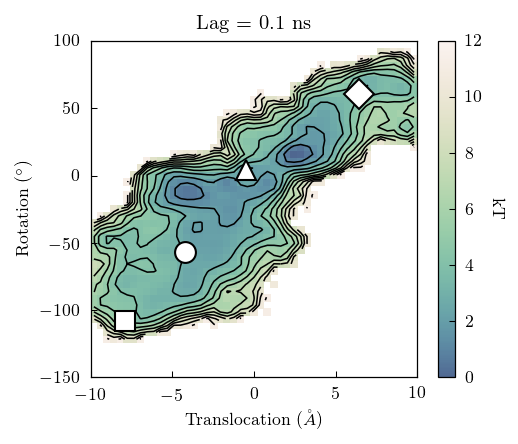

In [21]:
clines = np.linspace(0, 12, 13)
centerx = (xlim[1:] + xlim[:-1]) / 2
centery = (ylim[1:] + ylim[:-1]) / 2

f, ax = plt.subplots(figsize=(3.5, 3))

# calculate energy difference against minimum
min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
diff = -np.log(pmf.T) - min_energy
h = ax.pcolor(xlim, ylim, diff, cmap=cm_seq, vmax=12, label="kT")
cb = plt.colorbar(h, ax=ax)
cb.set_label("kT", rotation=-90, labelpad=10)
ax.contour(centerx, centery, diff, levels=clines, colors="black")
ax.set_title(f"Lag = 0.1 ns")
plotting.format_cvs(ax, centroids=True)
f.tight_layout()

In [30]:
sb_ids = [42, 48, 47, 53]

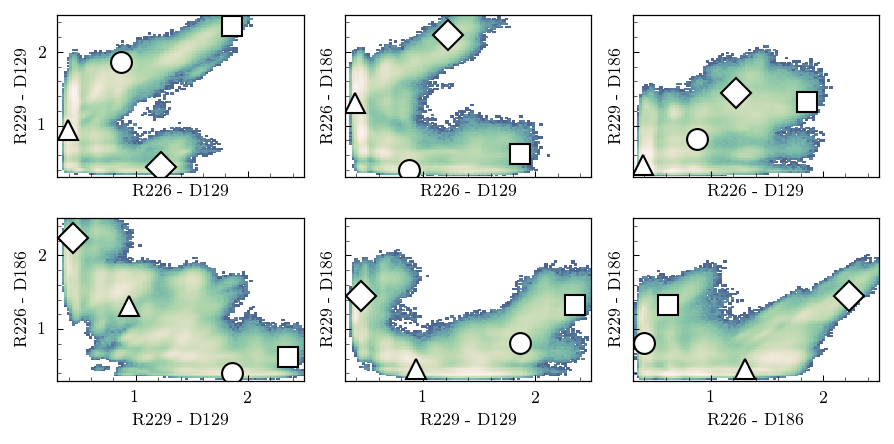

In [24]:
f, axes = plt.subplots(2, 3, figsize=(6, 3), sharex=True, sharey=True)

norm = mpl.colors.LogNorm()  # log scale
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    _, _, _, h = ax.hist2d(
        sb_arr[:, sb1],
        sb_arr[:, sb2],
        bins=100,
        range=[[0.3, 2.5], [0.3, 2.5]],
        cmin=0.001,
        density=True,
        cmap=cm_seq,
        norm=norm,
    )

    ax.set(xlabel=f"{sb_labels[sb1 - 30]}", ylabel=f"{sb_labels[sb2 - 30]}")
    ax.xaxis.set_minor_locator(ticker.AutoMinorLocator())
    ax.yaxis.set_minor_locator(ticker.AutoMinorLocator())

axes[0][0].set(xlim=[0.3, 2.5], ylim=[0.3, 2.5])
plotting.plot_sb_models(axes.flat, mode="du", centroids=True)
f.tight_layout()

In [25]:
# PMFs in sb space
pmfs_sb = []
sb1_lim = []
sb2_lim = []
for (sb1, sb2) in combinations(sb_ids, 2):
    sb1_trajs = [traj[:, sb1] for traj in sb_trajs]
    sb2_trajs = [traj[:, sb2] for traj in sb_trajs]
    xlim = np.linspace(np.min(sb_arr[:, sb1]), np.max(sb_arr[:, sb1]), 100)
    ylim = np.linspace(np.min(sb_arr[:, sb2]), np.max(sb_arr[:, sb2]), 100)
    sb1_lim.append(xlim)
    sb2_lim.append(ylim)
    pmfs_sb.append(
        extq.projection.density2d(sb1_trajs, sb2_trajs, weights[0], xlim, ylim)
    )

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


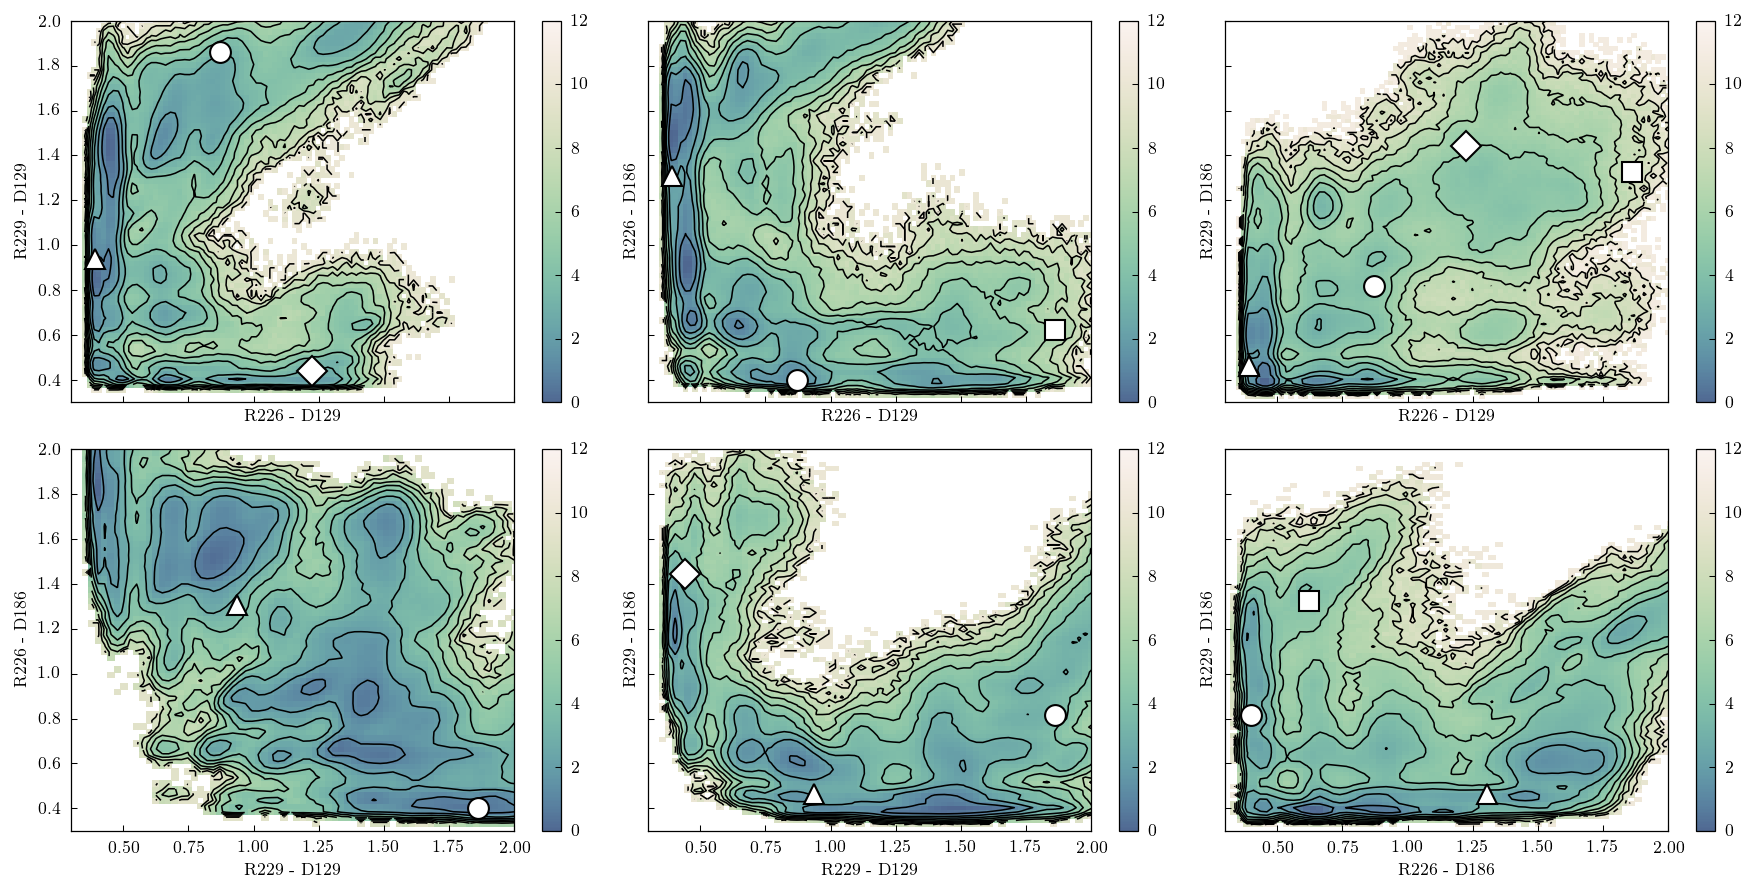

In [27]:
clines = np.linspace(0, 12, 13)
f, axes = plt.subplots(2, 3, figsize=(12, 6), sharex=True, sharey=True)

for ((sb1, sb2), ax, pmf, xlim, ylim) in zip(
    combinations(sb_ids, 2), axes.flat, pmfs_sb, sb1_lim, sb2_lim
):
    # compute grid
    centerx = (xlim[1:] + xlim[:-1]) / 2
    centery = (ylim[1:] + ylim[:-1]) / 2

    # calculate energy difference against minimum
    min_energy = np.min(-np.log(pmf[np.nonzero(pmf)]))
    diff = -np.log(pmf.T) - min_energy
    h = ax.pcolor(xlim, ylim, diff, cmap=cm_seq, vmax=12, label="kT")
    plt.colorbar(h, ax=ax)
    ax.contour(
        centerx,
        centery,
        diff,
        levels=clines,
        colors="black",
        linestyles="solid",
    )
    ax.set_xlabel(f"{sb_labels[sb1 - 30]}")
    ax.set_ylabel(f"{sb_labels[sb2 - 30]}")
    ax.set_xlim([0.3, 2.0])
    ax.set_ylim([0.3, 2.0])
plotting.plot_sb_models(axes.flat, centroids=True)
f.tight_layout()

# Committors

In [18]:
# guess functions
guess_down = np.zeros(len(cv_arr))
guess_down[down_ids] = 1
guessD = np.split(guess_down, split_inds)
guess_up = np.zeros(len(cv_arr))
guess_up[up_ids] = 1
guessU = np.split(guess_up, split_inds)
print(len(guessD), guessD[0].shape)
print(len(guessU), guessU[0].shape)

480 (10000,)
480 (10000,)


In [19]:
in_domain = np.split(mask, split_inds)
in_domain[0].shape

(10000,)

In [20]:
len(in_domain)

480

In [21]:
q_downup, qb_downup = [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 500
Calculating committors for lag 1000


In [22]:
import os

In [23]:
os.mkdir("../../data/feat2_ivac_ind1000_suppl")

In [24]:
np.save("../../data/feat2_ivac_ind1000_suppl/q_downup", q_downup)
np.save("../../data/feat2_ivac_ind1000_suppl/qb_downup", qb_downup)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/lib/npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


## PLot committors

In [25]:
import random

random.seed(123)

In [26]:
s = 10
N = len(cv_arr)
inds = random.sample(range(N), N // s)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:13: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  del sys.path[0]


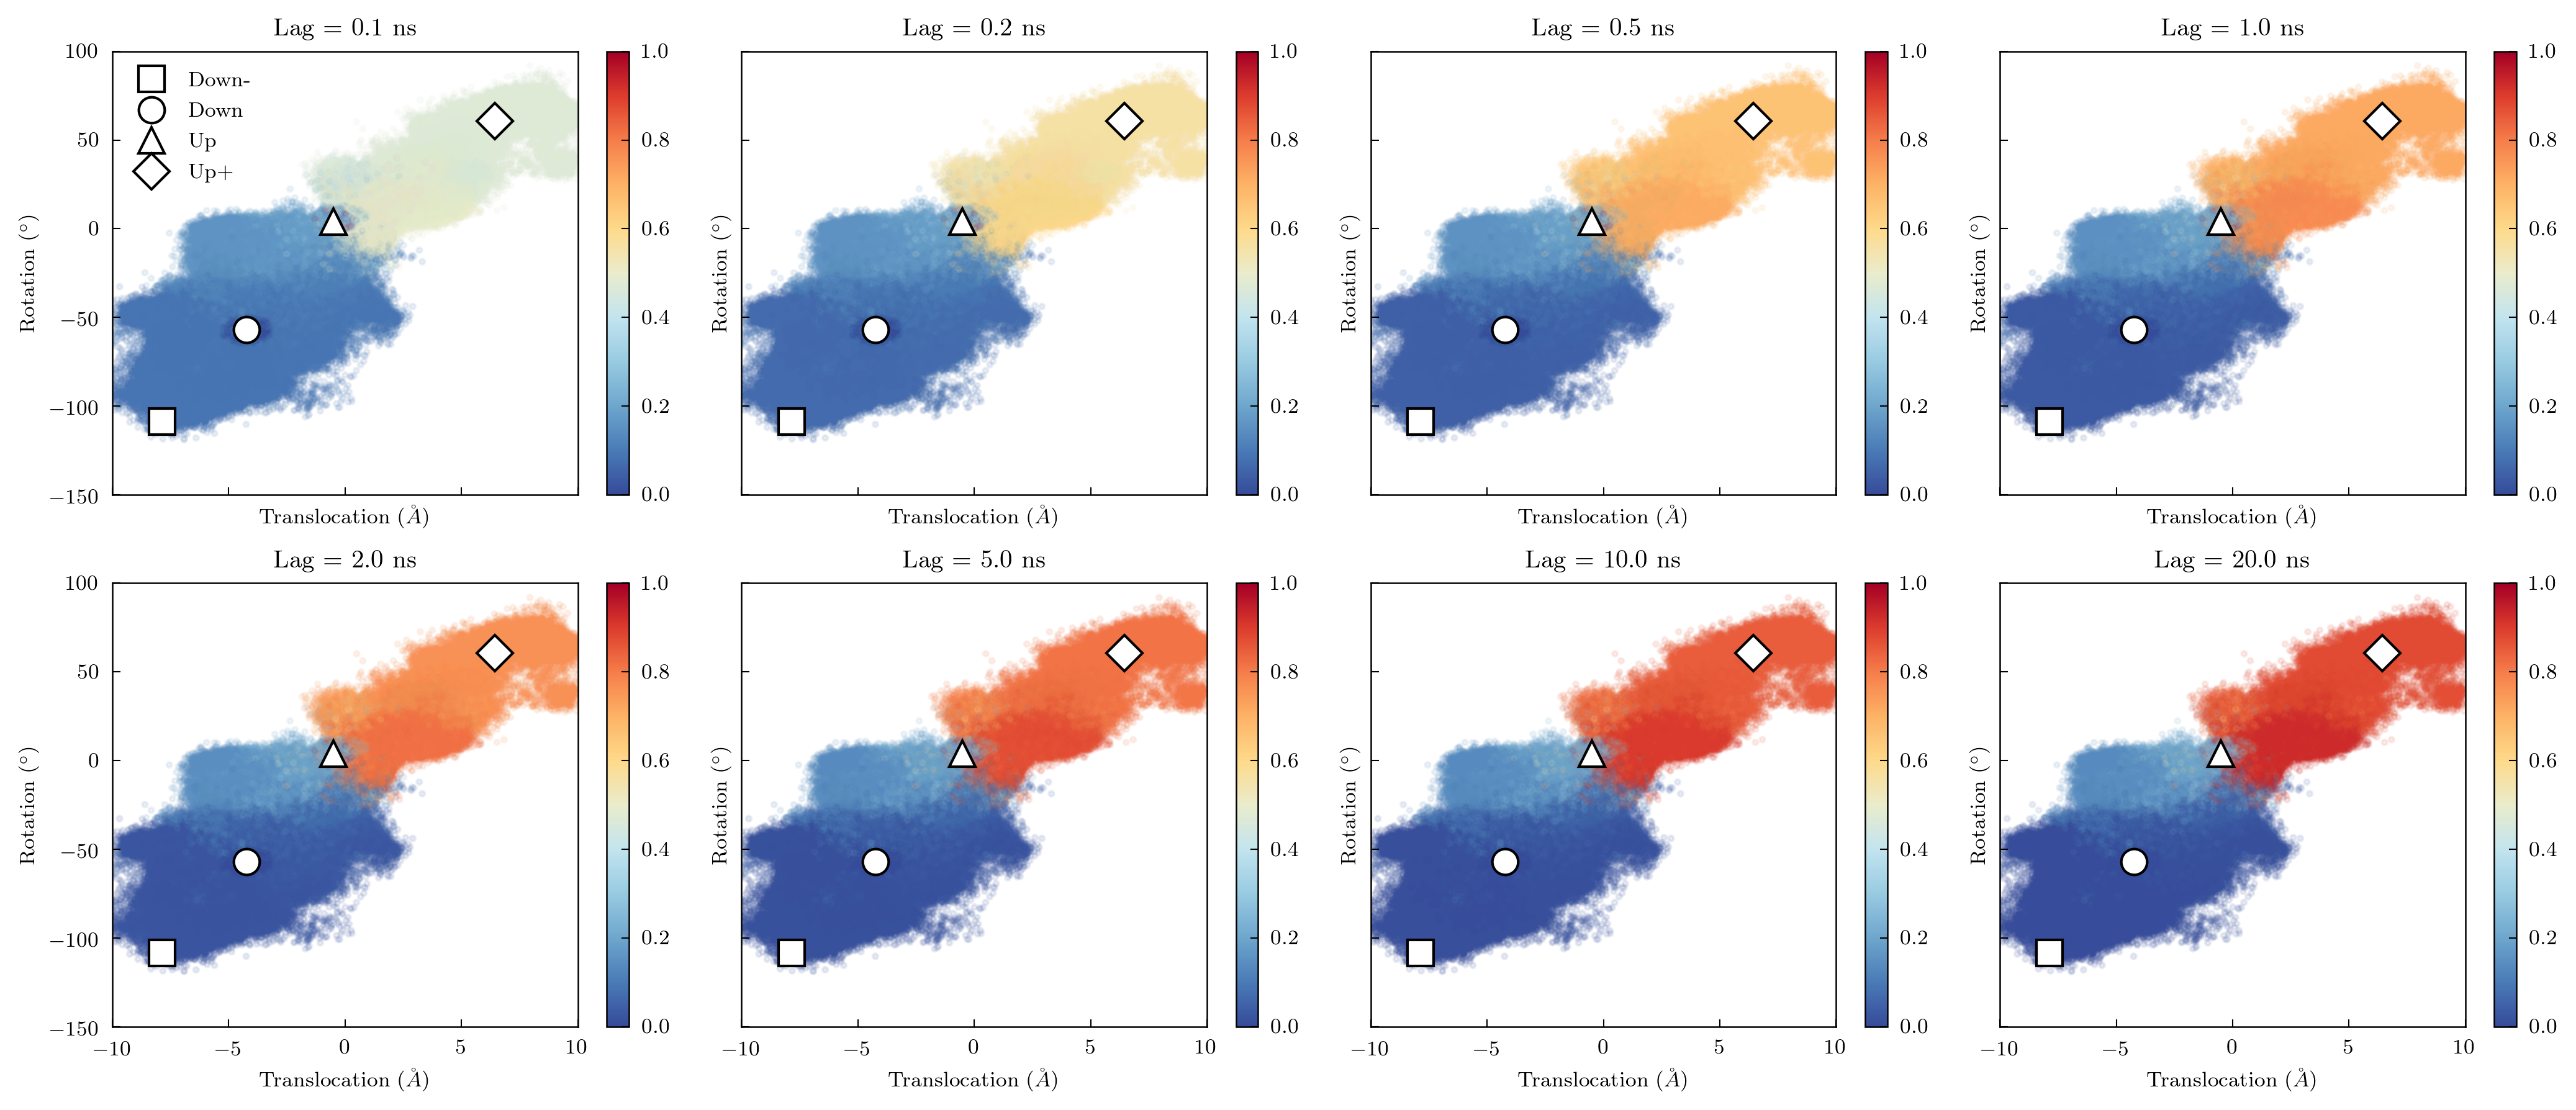

In [28]:
f, axs = plt.subplots(2, 4, figsize=(14, 6), sharex=True, sharey=True, dpi=300)
for lag, q, ax in zip(lags, q_downup, axs.flat):
    q_arr = np.concatenate(q).clip(min=0.0, max=1.0)
    h = ax.scatter(*cv_arr[inds].T, c=q_arr[inds], cmap=cm_div, alpha=0.1)
    cbar = plt.colorbar(h, ax=ax)
    cbar.solids.set(alpha=1)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    plotting.format_cvs(ax, centroids=True)
axs.flat[0].legend(["Down-", "Down", "Up", "Up+"])
f.tight_layout()

In [35]:
com = np.concatenate(weights[7])
q_arr = np.concatenate(q_downup[7])
q_dens, xe, ye = np.histogram2d(
    cv_arr[:, 0], cv_arr[:, 1], bins=100, density=False, weights=q_arr * com
)
w_dens, _, _ = np.histogram2d(
    cv_arr[:, 0], cv_arr[:, 1], bins=100, density=False, weights=com
)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'lag = 20 ns')

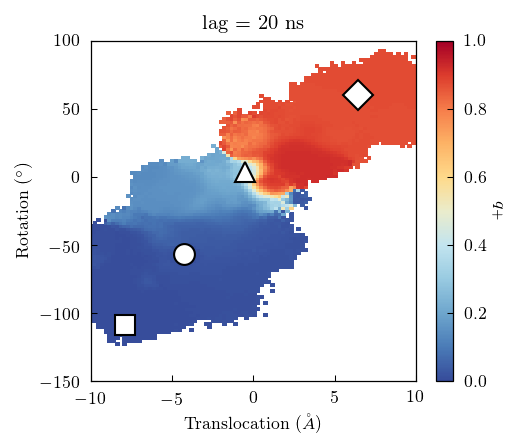

In [36]:
f, ax = plt.subplots(figsize=(3.5, 3))
h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_+$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True)
plt.title("lag = 20 ns")

In [37]:
com = np.concatenate(weights[7])
q_arr = np.concatenate(qb_downup[7])
q_dens, xe, ye = np.histogram2d(
    cv_arr[:, 0], cv_arr[:, 1], bins=100, density=False, weights=q_arr * com
)
w_dens, _, _ = np.histogram2d(
    cv_arr[:, 0], cv_arr[:, 1], bins=100, density=False, weights=com
)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


Text(0.5, 1.0, 'lag = 20 ns')

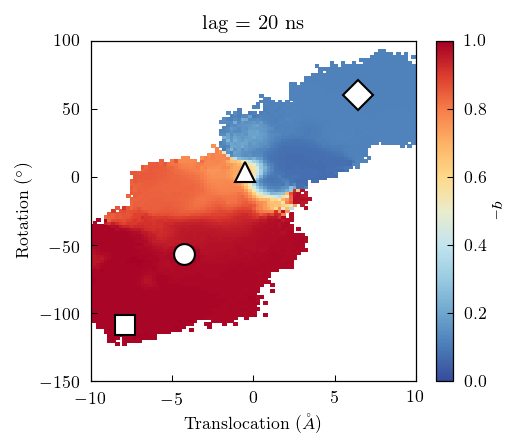

In [38]:
f, ax = plt.subplots(figsize=(3.5, 3))
h = ax.pcolor(xe, ye, (q_dens / w_dens).T, cmap=cm_div, vmin=0, vmax=1)
cb = plt.colorbar(h, ax=ax)
cb.set_label("$q_-$", rotation=-90, labelpad=10)
plotting.format_cvs(ax, centroids=True)
plt.title("lag = 20 ns")

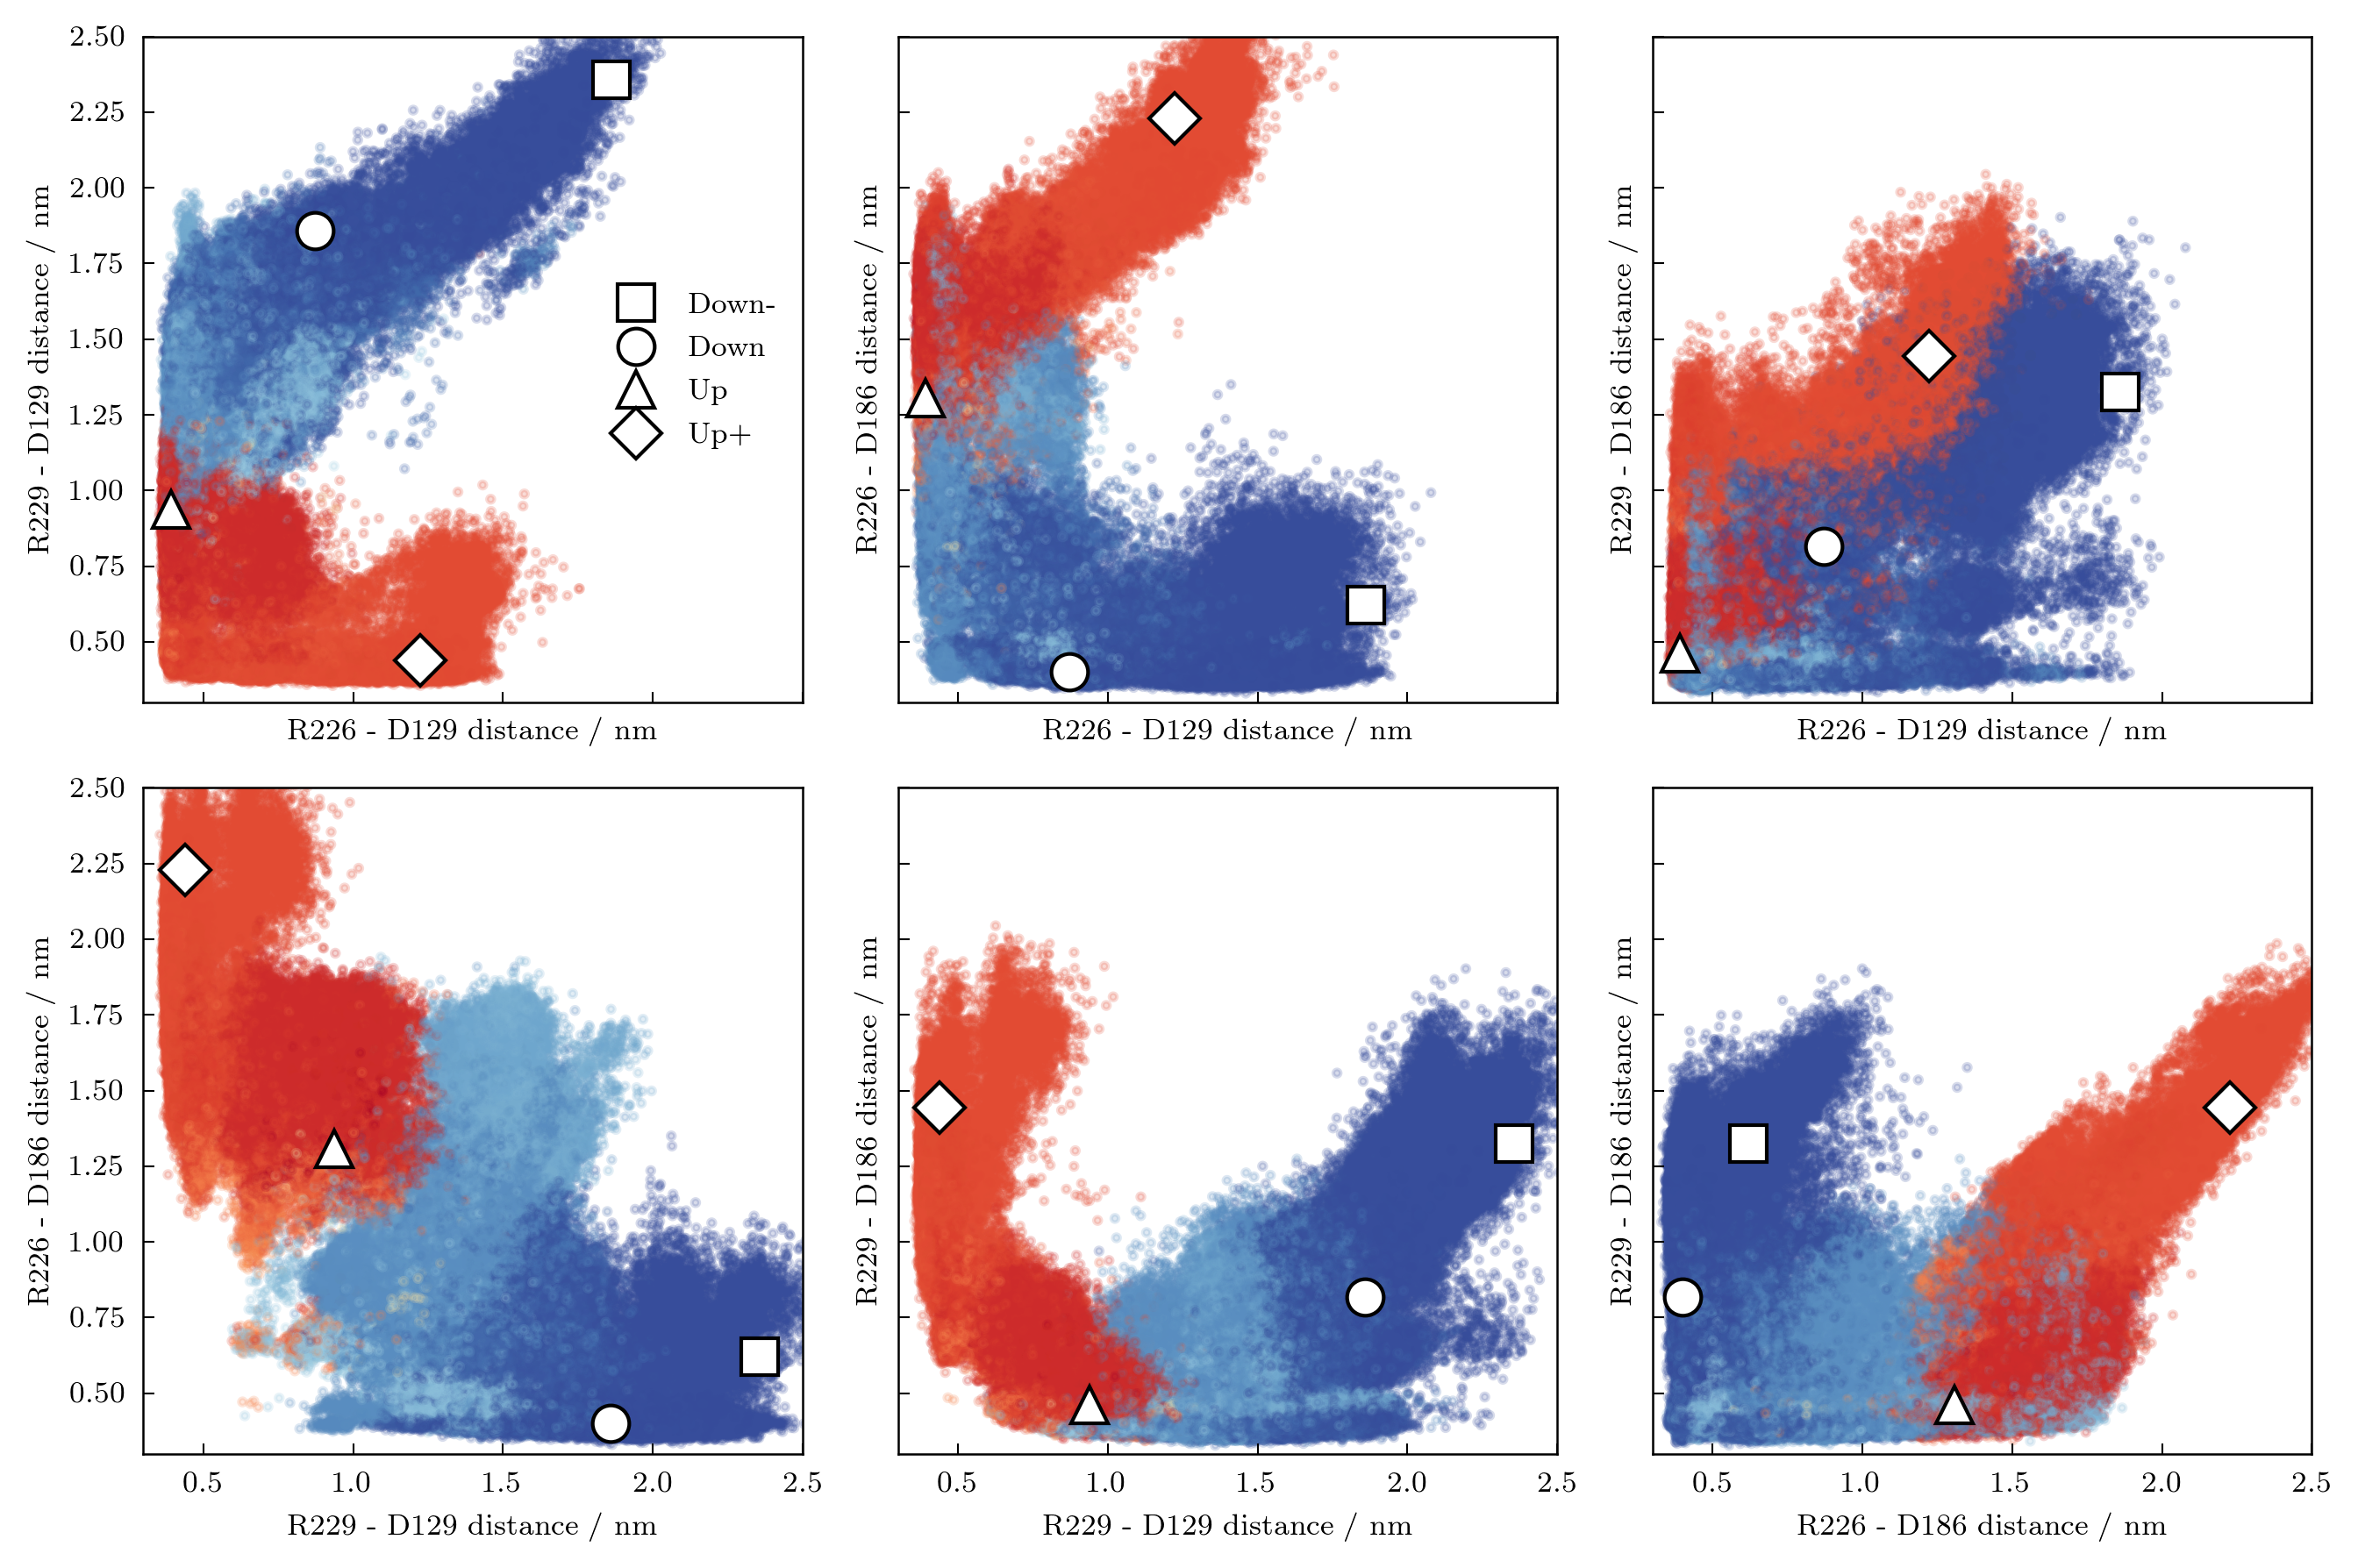

In [31]:
f, axes = plt.subplots(2, 3, figsize=(9, 6), sharex=True, sharey=True, dpi=300)

q_arr = np.concatenate(q_downup[7])
for ((sb1, sb2), ax) in zip(combinations(sb_ids, 2), axes.flat):
    h = ax.scatter(
        sb_arr[inds, sb1], sb_arr[inds, sb2], c=q_arr[inds], cmap=cm_div, alpha=0.2
    )
    ax.set(
        xlabel=f"{sb_labels[sb1 - 30]} distance / nm",
        ylabel=f"{sb_labels[sb2 - 30]} distance / nm",
        xlim=[0.3, 2.5],
        ylim=[0.3, 2.5],
    )
# cbar = f.colorbar(h, ax=axes.ravel().tolist())
# cbar.solids.set(alpha=1)

plotting.plot_sb_models(axes.flat, mode="du", centroids=True)
axes[0][0].legend(["Down-", "Down", "Up", "Up+"], loc="right")

# plt.suptitle(f"Committor, lag = {lags[7] * 0.1} ns")
f.tight_layout()

# 3D projections

In [32]:
centroids = np.loadtxt("../../models/MD-clustering-center/all.txt")

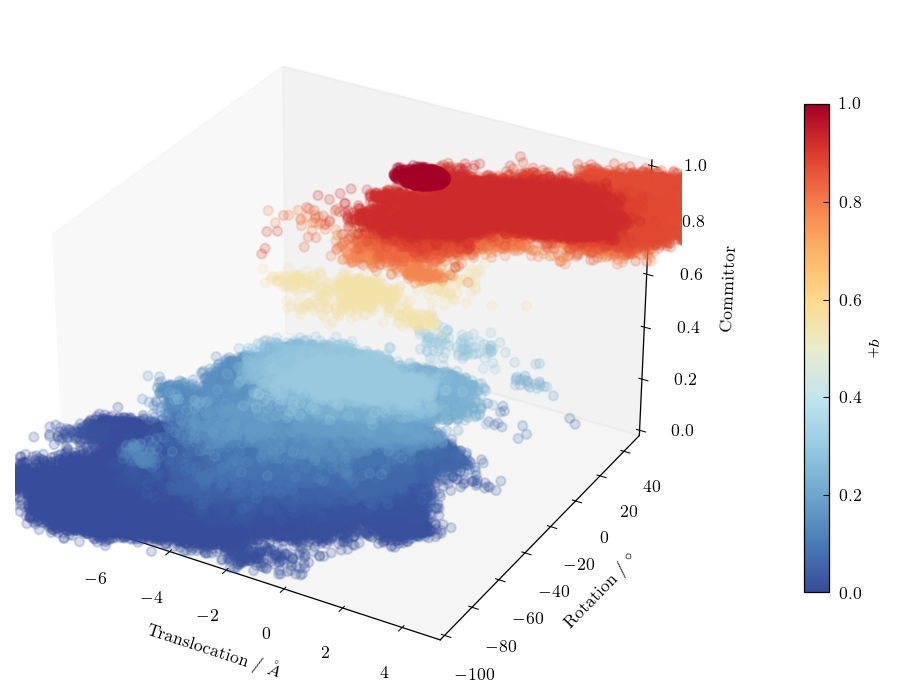

In [46]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

q = np.concatenate(q_downup[7])
ax.scatter(cv_arr[inds, 0], cv_arr[inds, 1], q[inds], c=q[inds], cmap=cm_div, alpha=0.2)
ax.set_xlabel("Translocation / $\AA$")
ax.set_ylabel("Rotation / $^\circ$")
ax.set_zlabel("Committor")
ax.set_xlim([-7.5, 5])
ax.set_ylim([-100, 50])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.15, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
cbar.set_label("$q_+$", rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 10 ns lag')

# ax.plot(centroids[1, 0], centroids[1, 1], 0,
#         'o', mec='k', mfc='w', ms=8)
# ax.plot(centroids[2, 0], centroids[2, 1], 1,
#         '^', mec='k', mfc='w', ms=8)
# ax.legend(['Down', 'Up'], loc='upper left')

In [35]:
feat2_models = np.load("../../data/models_centroids_feat2.npy")

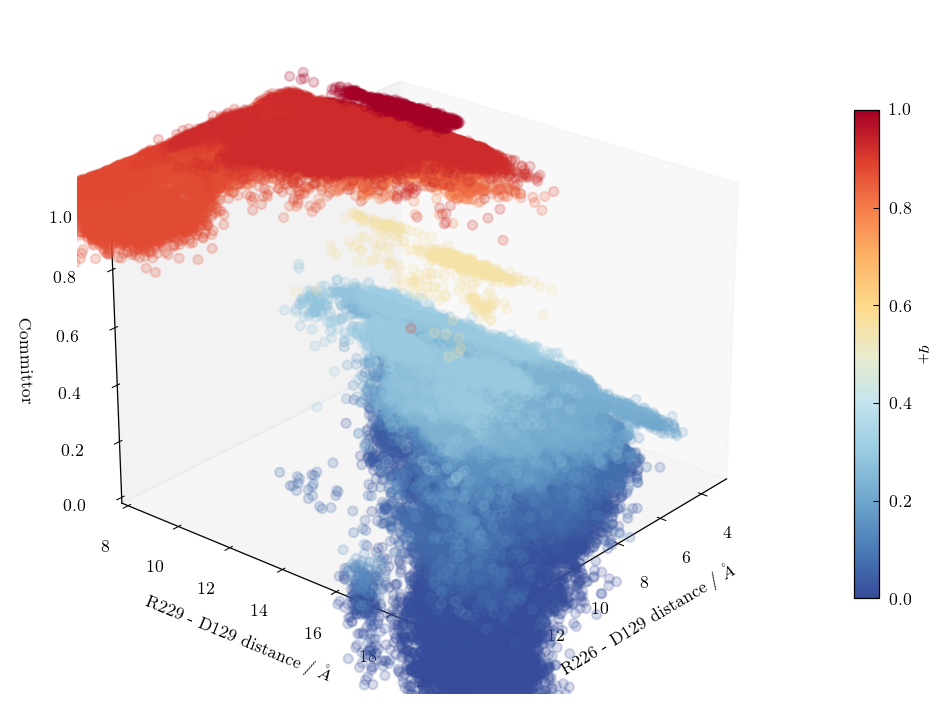

In [49]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

ax.scatter(
    sb_arr[inds, sb_ids[0]] * 10,
    sb_arr[inds, sb_ids[1]] * 10,
    q[inds],
    c=q[inds],
    cmap=cm_div,
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]} distance / $\AA$")
ax.set_ylabel(f"{sb_labels[sb_ids[1] - 30]} distance / $\AA$")
ax.set_zlabel("Committor")
ax.set_xlim([3, 15])
ax.set_ylim([8, 20])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.12, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
cbar.set_label("$q_+$", rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 20 ns lag')

# ax.plot(feat2_models[1, sb_ids[0]] * 10, feat2_models[1, sb_ids[1]] * 10, 0,
#         'o', mec='k', mfc='w', ms=8)
# ax.plot(feat2_models[2, sb_ids[0]] * 10, feat2_models[2, sb_ids[1]] * 10, 1,
#         '^', mec='k', mfc='w', ms=8)
# ax.legend(['Down', 'Up'], loc='upper right')

ax.view_init(azim=40, elev=25)

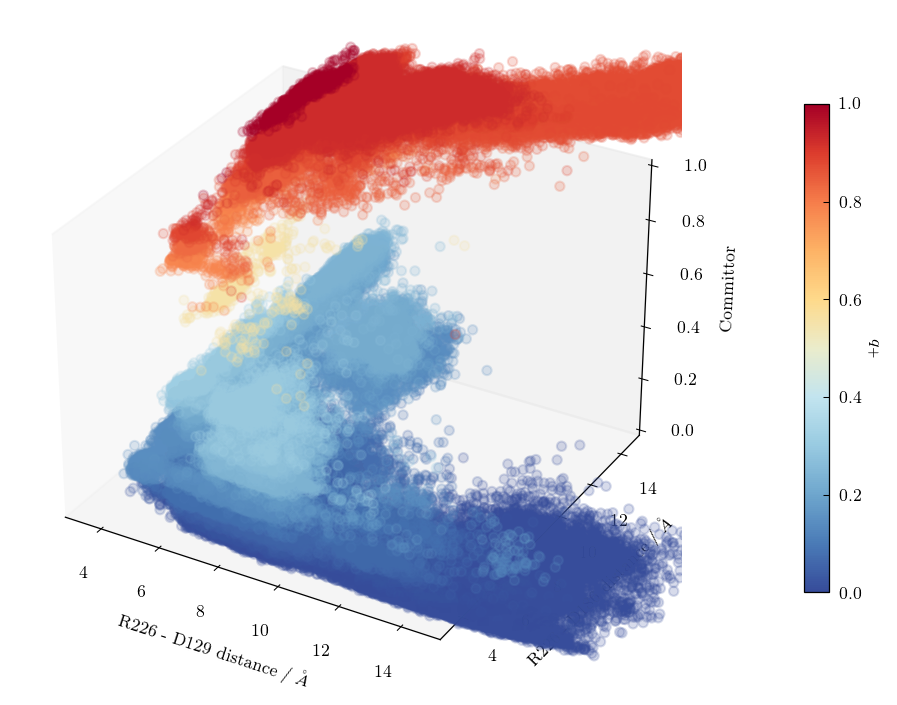

In [48]:
f = plt.figure(figsize=(7, 6))
ax = f.add_subplot(projection="3d")

ax.scatter(
    sb_arr[inds, sb_ids[0]] * 10,
    sb_arr[inds, sb_ids[2]] * 10,
    q[inds],
    c=q[inds],
    cmap=cm_div,
    alpha=0.2,
)
ax.set_xlabel(f"{sb_labels[sb_ids[0] - 30]} distance / $\AA$")
ax.set_ylabel(f"{sb_labels[sb_ids[2] - 30]} distance / $\AA$")
ax.set_zlabel("Committor")
ax.set_xlim([3, 15])
ax.set_ylim([3, 15])
ax.set_zlim([0, 1.0])
cbar = plt.colorbar(h, ax=ax, pad=0.15, fraction=0.03, label="$q_+$")
cbar.solids.set(alpha=1)
cbar.set_label("$q_+$", rotation=-90, labelpad=10)
# ax.set_title('Committor, down to up transition, 20 ns lag')

# ax.plot(feat2_models[1, sb_ids[0]] * 10, feat2_models[1, sb_ids[2]] * 10, 0,
#         'o', mec='k', mfc='w', ms=8)
# ax.plot(feat2_models[2, sb_ids[0]] * 10, feat2_models[2, sb_ids[2]] * 10, 1,
#         '^', mec='k', mfc='w', ms=8)
# ax.legend(['Down', 'Up'], loc='upper right')

# ax.view_init(azim=40, elev=25)